In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.svm import LinearSVC, SVC

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFE, RFECV, f_classif

from sklearn.decomposition import PCA

In [2]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Import

In [3]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [4]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [5]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Prep

In [6]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log', 'emp_length_val']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified', 'term_bin']

cat_attr = ['purpose', 'home_ownership']

In [7]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Standardize data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [8]:
X_train_full = feature_prep.fit_transform(data['train'])

In [9]:
X_test = feature_prep.transform(data['test'])

In [10]:
X_train_full.shape, X_test.shape

((152218, 44), (38055, 44))

In [11]:
y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

y_train_full.shape, y_test.shape

((152218,), (38055,))

In [12]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols

In [13]:
feature_names = get_feature_prep_columns(feature_prep)
len(feature_names)

44

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Scoring

Continuing the approach used with our logistic regression analysis, we will be using F2 score as a means of prioritizing recall over precision:

In [15]:
f2_score = make_scorer(fbeta_score, beta=2)

### Linear SVC

##### Basic Model

In [55]:
lsvc_basic = LinearSVC(class_weight='balanced')

In [56]:
my_func.run_time(reset=True)
lsvc_basic.fit(X_train, y_train)
my_func.run_time()

Time: 24.30s 


In [57]:
my_func.classifier_summary(y_train, lsvc_basic.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               64189               34125
Actual Positive                8168               15292
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.533726
Recall           0.651833
Precision (pos)  0.309448
Precision (neg)  0.887115
Specificity      0.652898


In [58]:
my_func.classifier_summary(y_val, lsvc_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16132                8498
Actual Positive                2026                3788
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.532891
Recall           0.651531
Precision (pos)  0.308318
Precision (neg)  0.888424
Specificity      0.654974


##### Learning Curve

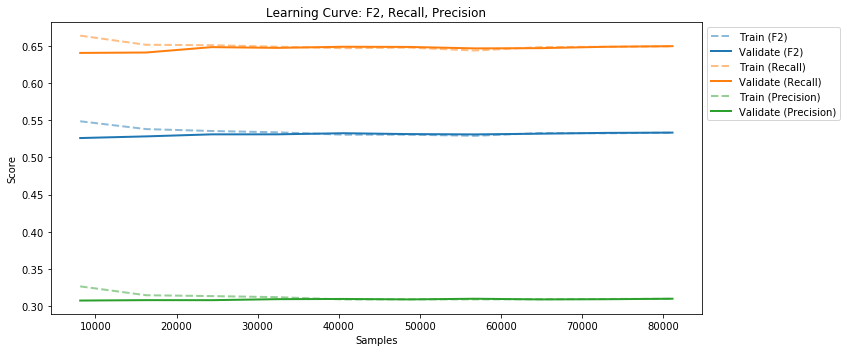

In [59]:
my_func.plot_learning_curve(lsvc_basic, X_train, y_train, scoring=['f2', 'recall', 'precision'], train_sizes=np.arange(0.1,1.1,0.1), n_jobs=4)

Our scores seem to stabalize around 40,000 samples. Given the extreme impact of sample size on the computational complexity for SVC, reducing to 40,000 samples may provide a more practical approach without much impact on model performance:

In [61]:
rand_ind = np.random.choice(np.arange(0, X_train.shape[0], 1), size=40000, replace=False)

X_train_s = X_train[rand_ind]
y_train_s = y_train.iloc[rand_ind]

In [62]:
my_func.run_time(reset=True)
lsvc_basic.fit(X_train_s, y_train_s)
my_func.run_time()

Time: 6.75s 


In [85]:
my_func.print_cvs(cross_val_score(lsvc_basic, X_train_s, y_train_s, cv=3, scoring=f2_score), 'f2')

Mean f2 score = 0.526 (+/- 0.009)


In [65]:
my_func.classifier_summary(y_train_s, lsvc_basic.predict(X_train_s));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               21183               11244
Actual Positive                2668                4905
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.528089
Recall           0.647696
Precision (pos)  0.303734
Precision (neg)  0.888139
Specificity      0.653252


In [66]:
my_func.classifier_summary(y_val, lsvc_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16145                8485
Actual Positive                2041                3773
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.531199
Recall           0.648951
Precision (pos)  0.307799
Precision (neg)  0.887771
Specificity      0.655501


Our reduced sample model performs nearly identically to the full training set, with scores only suffering on the magnitude of 0.01 and litte signs of over-/under-fitting.

##### Feature Selection

Given the significantly higher computation times for even LinearSVC as a result of the large number of training instances, perhaps some improvements can also be made to both fit times and model performance via feature selection. Given our learning curve results above, we should be able to perform optimizations using 40,000 samples without a signficiant cost to accuracy.

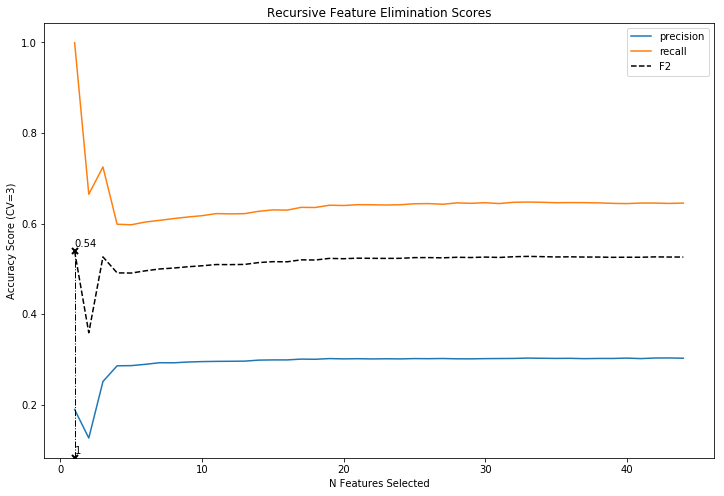

In [67]:
RFE_scores = my_func.plot_RFE(estimator=LinearSVC(class_weight='balanced'), X=X_train_s, y=y_train_s, f_score=True, beta=2, n_jobs=4)

We seem to be encountering a similar issue as our Logistic Regression RFE process, in which only 1 feature is being selected. For the same reasons of one feature being too biased and inflexible, we will seek out the next highest score:

In [80]:
# Index = n_features since we start at [1:]
np.argmax(RFE_scores['F2'][1:])

31

In [83]:
lsvc_rfe = Pipeline([('rfe', RFE(estimator=LinearSVC(class_weight='balanced'), n_features_to_select=31)),
                     ('estimator', LinearSVC(class_weight='balanced'))])

lsvc_rfe.fit(X_train_s, y_train_s);

In [84]:
lsvc_rfe_cvs = cross_val_score(lsvc_rfe, X_train_s, y_train_s, cv=3, scoring=f2_score)
my_func.print_cvs(lsvc_rfe_cvs)

Mean CV score = 0.525 (+/- 0.010)


In [86]:
my_func.classifier_summary(y_train_s, lsvc_rfe.predict(X_train_s));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               21121               11306
Actual Positive                2655                4918
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.528635
Recall           0.649412
Precision (pos)  0.303131
Precision (neg)  0.888333
Specificity      0.651340


In [87]:
my_func.classifier_summary(y_val, lsvc_rfe.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16103                8527
Actual Positive                2039                3775
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.530823
Recall           0.649295
Precision (pos)  0.306861
Precision (neg)  0.887609
Specificity      0.653796


Our model performs almost identically to previous versions, whilst reducing the the number of features to 31. Running through this via pipeline takens longer than our default fit due to having to run through both the RFE and LinearSVC. However, for the purposes of subsequent tuning if we extract the RFE process to obtain a new transformed training set we should see at least some improvements to computation times.

In [30]:
rfe = RFE(estimator=LinearSVC(class_weight='balanced'), n_features_to_select=31)
rfe.fit(X_train_s, y_train_s)

RFE(estimator=LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
  n_features_to_select=31, step=1, verbose=0)

In [31]:
X_train_s_rfe = rfe.transform(X_train_s)

##### Parameter Tuning

First, we will take a look at how variations to C alone impact performance (with default L2 penalty and squared hinge loss):

In [100]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': np.logspace(-9,3,13)}
              

lsvc_C_gs = GridSearchCV(estimator=LinearSVC(class_weight='balanced', tol=0.001), # Slightly reduce tol to improve comp time
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lsvc_C_gs.fit(X_train_s_rfe, y_train_s)
my_func.run_time()

Time: 22.64s 


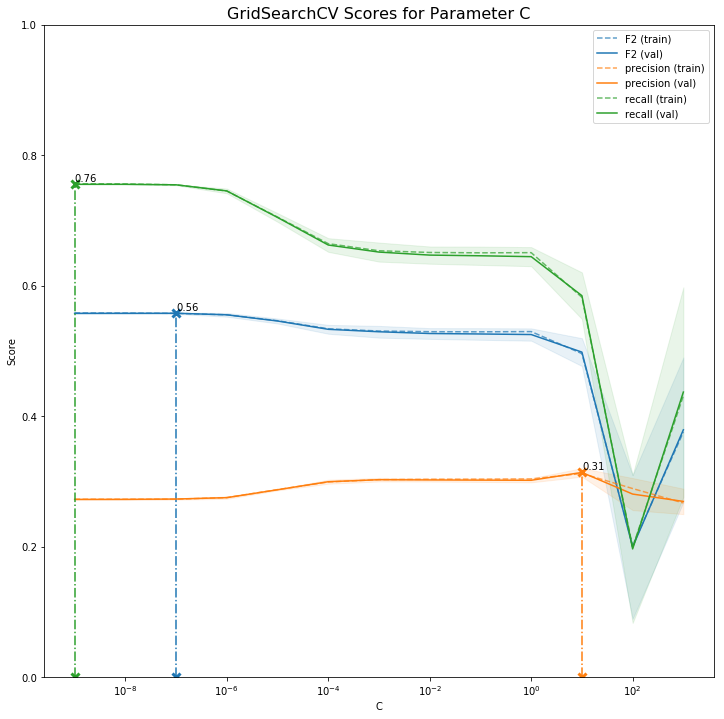

In [101]:
my_func.plot_gs_param(lsvc_C_gs, set_xscale='log')

We can see that lower C values produce favorable recall and F2 scores. As for the performance of regularization across L1 and L2 penalty:

In [103]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': np.logspace(-9,0,10),
              'penalty': ['l1', 'l2']}
              

lsvc_pen_gs = GridSearchCV(estimator=LinearSVC(class_weight='balanced', dual=False, tol=0.001), # Slightly reduce tol to improve comp time
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lsvc_pen_gs.fit(X_train_s_rfe, y_train_s)
my_func.run_time()

Time: 8.53s 


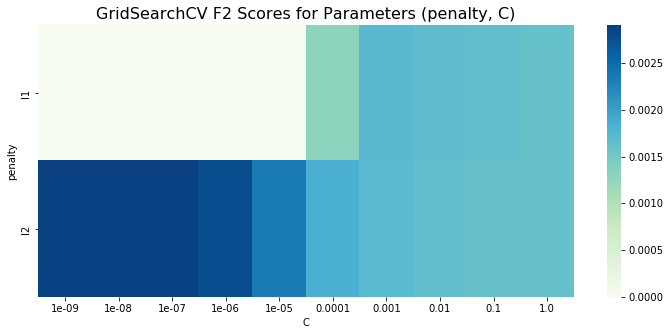

In [112]:
my_func.plot_gs_param_dual(lsvc_pen_gs, cbar=True, scoring='F2', power_scale=10, swap_axes=True, figsize=(12,5))

With this basic comparison, it would seem that L2 penalty produces better results than L1. We will proceed with a full gridsearch of both penalties with various loss combinations as well to ensure we are not missing any edge cases which perform best:

In [117]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = [{'C': np.logspace(-9,0,10),
               'loss': ['squared_hinge'],
               'dual': [False],
               'penalty': ['l1', 'l2']},
              {'C': np.logspace(-9,0,10),
               'loss': ['hinge'],
               'dual': [True],
               'penalty': ['l2']}]
              

lsvc_gs = GridSearchCV(estimator=LinearSVC(class_weight='balanced', tol=0.001), # Slightly reduce tol to improve comp time
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lsvc_gs.fit(X_train_s_rfe, y_train_s)
my_func.run_time()

Time: 10.02s 


In [118]:
my_func.gs_score_summary(lsvc_gs)

--------------------
Best F2:
Params: {'C': 9.9999999999999995e-08, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
F2 = 0.5576169613083233
Recall = 0.7545227382396322
Precision = 0.2728258047592347
--------------------
Best Recall:
Params: {'C': 1.0000000000000001e-09, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
F2 = 0.5575061543539285
Recall = 0.7553149842541307
Precision = 0.2722808360084937
--------------------
Best Precision:
Params: {'C': 0.001, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
F2 = 0.5292348669507614
Recall = 0.6513951324786995
Precision = 0.3024508042244662
--------------------


With our high levels of regularization, it should be feasible to return to using our full training set for scoring:

In [35]:
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)

In [36]:
lsvc_best = LinearSVC(class_weight='balanced', loss='squared_hinge', dual=False, penalty='l2', C=1e-7)

my_func.run_time(reset=True)
lsvc_best.fit(X_train_rfe, y_train)
my_func.run_time()

Time: 205ms 


In [135]:
my_func.classifier_summary(y_train, lsvc_best.predict(X_train_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               52826               45488
Actual Positive                5867               17593
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.560569
Recall           0.749915
Precision (pos)  0.278895
Precision (neg)  0.900039
Specificity      0.537319


In [137]:
my_func.classifier_summary(y_val, lsvc_best.predict(X_val_rfe));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               13258               11372
Actual Positive                1471                4343
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.557209
Recall           0.746990
Precision (pos)  0.276360
Precision (neg)  0.900129
Specificity      0.538287


##### PCA

Although we already performed feature selection, perhaps PCA will perform better. We will repeat grid search parameter tuning using the sample training set (for performance reasons), this time adding different levels of PCA components:

In [18]:
rand_ind = np.random.choice(np.arange(0, X_train.shape[0], 1), size=40000, replace=False)

X_train_s = X_train[rand_ind]
y_train_s = y_train.iloc[rand_ind]

In [20]:
lr_pca = Pipeline([('pca', PCA()),
                     ('estimator', LinearSVC(tol=0.001))])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision',
           'specificity': make_scorer(my_func.binary_specificity)}

param_grid = [{'estimator__C': np.logspace(-9,0,10),
              'estimator__class_weight': ['balanced'],
              'estimator__penalty': ['l1', 'l2'],
              'estimator__loss': ['squared_hinge'],
              'estimator__dual': [False],
              'pca__n_components': [None, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]},
             {'estimator__C': np.logspace(-9,0,10),
              'estimator__class_weight': ['balanced'],
              'estimator__dual': [True],
              'estimator__penalty': ['l2'],
              'estimator__loss': ['hinge'],
              'pca__n_components': [None, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]}]

lr_pca_gs = GridSearchCV(estimator=lr_pca,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_pca_gs.fit(X_train_s_r, y_train_s);
my_func.run_time()

Time: 2min 25s 


In [22]:
my_func.gs_score_summary(lr_pca_gs)

--------------------
Best F2:
Params: {'estimator__C': 9.9999999999999995e-07, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': 0.95}
F2 = 0.5482572884825149
Recall = 0.7236221751968503
Precision = 0.2784130443545622
Specificity = 0.5585855926222503
--------------------
Best Recall:
Params: {'estimator__C': 1e-08, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': 0.95}
F2 = 0.5481408214925722
Recall = 0.7261156200787402
Precision = 0.2768007461205925
Specificity = 0.5534898550555203
--------------------
Best Precision:
Params: {'estimator__C': 1.0, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': 0.999}
F2 = 0.5315660269855523
Recall = 0.6502624507874015
Precision = 0.30725038847266906
Spe

In [24]:
lr_pca_best = Pipeline([('pca', PCA(n_components=0.95)),
                     ('estimator', LinearSVC(class_weight='balanced', C=1e-6, loss='squared_hinge', penalty='l2', dual=False))])

lr_pca_best.fit(X_train, y_train);

In [25]:
lr_pca_best.named_steps['pca'].n_components_

21

In [27]:
lr_pca_cvs = cross_val_score(lr_pca_best, X_train, y_train, scoring=f2_score, n_jobs=4)

my_func.print_cvs(lr_pca_cvs, 'f2')

Mean f2 score = 0.551 (+/- 0.002)


In [28]:
my_func.classifier_summary(y_train, pca_best.predict(X_train));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               56580               41734
Actual Positive                6670               16790
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.550983
Recall           0.715686
Precision (pos)  0.286891
Precision (neg)  0.894545
Specificity      0.575503


In [29]:
my_func.classifier_summary(y_val, pca_best.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               14185               10445
Actual Positive                1658                4156
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.548908
Recall           0.714826
Precision (pos)  0.284638
Precision (neg)  0.895348
Specificity      0.575924


PCA alone is not able to exceed the performance of our RFE approach. We will see if adding PCA on top of our original RFE feature selection provides any additional benefits:

In [32]:
lr_rfe_pca = Pipeline([('pca', PCA()),
                     ('estimator', LinearSVC(tol=0.001))])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision',
           'specificity': make_scorer(my_func.binary_specificity)}

param_grid = [{'estimator__C': np.logspace(-9,0,10),
              'estimator__class_weight': ['balanced'],
              'estimator__penalty': ['l1', 'l2'],
              'estimator__loss': ['squared_hinge'],
              'estimator__dual': [False],
              'pca__n_components': [None, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]},
             {'estimator__C': np.logspace(-9,0,10),
              'estimator__class_weight': ['balanced'],
              'estimator__dual': [True],
              'estimator__penalty': ['l2'],
              'estimator__loss': ['hinge'],
              'pca__n_components': [None, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]}]

lr_rfe_pca_gs = GridSearchCV(estimator=lr_rfe_pca,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_rfe_pca_gs.fit(X_train_s_rfe, y_train_s);
my_func.run_time()

Time: 2min 18s 


In [33]:
my_func.gs_score_summary(lr_rfe_pca_gs)

--------------------
Best F2:
Params: {'estimator__C': 1e-08, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5524182649937198
Recall = 0.729658937007874
Precision = 0.28020377818647724
Specificity = 0.5588635446991331
--------------------
Best Recall:
Params: {'estimator__C': 1.0000000000000001e-09, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': 0.5}
F2 = 0.5498082547608021
Recall = 0.7299213779527559
Precision = 0.27671583356949975
Specificity = 0.5509883098014156
--------------------
Best Precision:
Params: {'estimator__C': 0.01, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'pca__n_components': None}
F2 = 0.5307330037425086
Recall = 0.6496062992125984
Precision = 0.30644750907536955
Spe

Our best F2 score requires utilizing all components, so PCA is unable to provide any additional improvement over RFE.

##### PR Curve

..\src\functions\my_functions.py:337: RuntimeWarning: invalid value encountered in true_divide
  f_scores = (1 + beta**2) * (precisions * recalls) / ((beta**2 * precisions) + recalls)


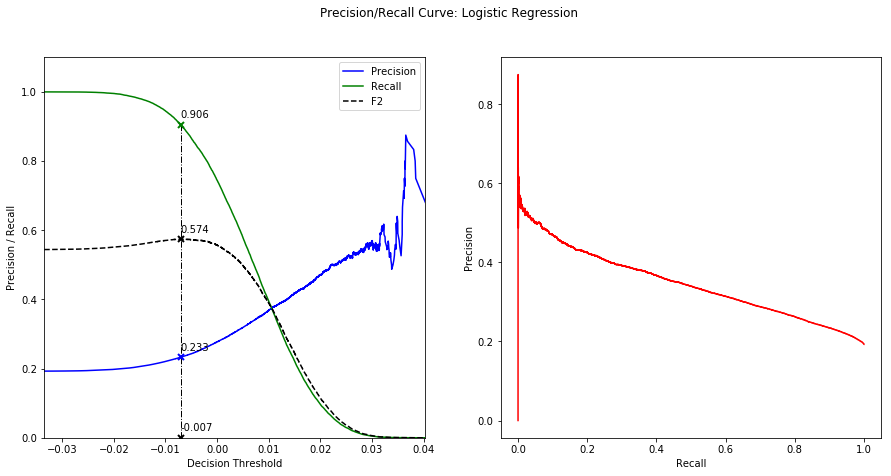

In [37]:
precisions, recalls, thresholds = my_func.plot_pr_curve(lsvc_best, X_train, y_train, f_score=True, beta=2, label='Logistic Regression')

Changing the decision threshold to maximize F2 can lead to a recall score of approx. 0.9, but it reduces our precision below our desired minimum of 0.25. Perhaps a slightly more conservative value, i.e. -0.002, will yield a better balance:

In [42]:
# Filter results based off new threshold
t = -0.002

y_train_pred_t = lsvc_best.decision_function(X_train_rfe) > t
y_val_pred_t = lsvc_best.decision_function(X_val_rfe) > t

In [43]:
my_func.classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               48742               49572
Actual Positive                5138               18322
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.566424
Recall           0.780989
Precision (pos)  0.269862
Precision (neg)  0.904640
Specificity      0.495779


In [44]:
my_func.classifier_summary(y_val, y_val_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               12265               12365
Actual Positive                1281                4533
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.564452
Recall           0.779670
Precision (pos)  0.268257
Precision (neg)  0.905433
Specificity      0.497970


Whilst we have managed to increase recall to 0.77 via this new threshold, specificty has decreased below 0.5 meaning we are losing over half of our healthy loans as false positives. From a business standpoint this is unlikely to be an acceptable loss.

### Polynomial SVC

##### Learning Curve

As seen during the MVP analysis, computing this model takes an extremely long time due to the number of training instances. Consequently, we will see how the model performs in the 10-90% sample size range to see if it is feasible to work with a smaller training sample:

[learning_curve] Training set sizes: [ 8118 24354 40591 56827]


[Parallel(n_jobs=4)]: Done   3 out of  12 | elapsed:  1.8min remaining:  5.4min
[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed:  6.5min remaining:  3.3min
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 13.8min finished


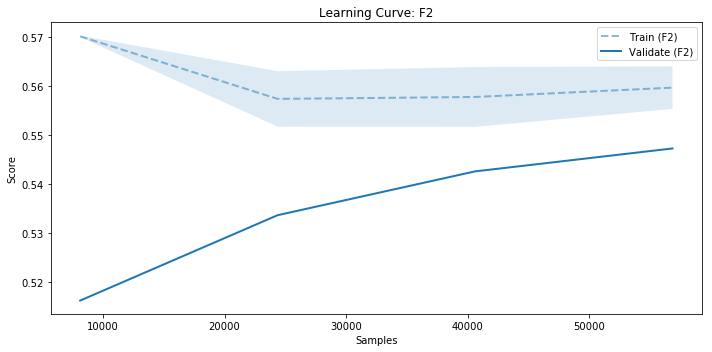

In [73]:
my_func.plot_learning_curve(SVC(class_weight='balanced', kernel='poly', degree=2), X_train, y_train, scoring='f2', train_sizes=[0.1,0.3,0.5,0.7,0.9], n_jobs=4, verbose=3)

Whilst there is still room for improvement between the train and validation scores, noting the scale of the graph above we only have a score difference on the magnitude of 0.02 at the 40,000 sample mark. We will consequently attempt to optimize our models using this sample size to reduce computation times, with the understanding that our resulting scores may suffer slightly.

##### Basic Model

Using a sample size of 40,000 we will see how the untuned polynomial SVC models perform. The MVP only evaluated the 2nd degree, so we will also make a quick comparison between 2nd and 3rd degree models to see which might perform best.

In [37]:
rand_ind = np.random.choice(np.arange(0, X_train.shape[0], 1), size=40000, replace=False)

X_train_s = X_train[rand_ind]
y_train_s = y_train.iloc[rand_ind]

In [75]:
psvc_d2_basic = SVC(kernel='poly', degree=2, class_weight='balanced', cache_size=2000)

my_func.run_time(reset=True)
psvc_d2_basic.fit(X_train_s, y_train_s)
my_func.run_time()

Time: 1min 58s 


In [77]:
psvc_d2_cvs = cross_val_score(psvc_d2_basic, X_train_s, y_train_s, cv=3, scoring=f2_score)
my_func.print_cvs(psvc_d2_cvs)

Mean CV score = 0.542 (+/- 0.003)


In [79]:
my_func.classifier_summary(y_train_s, psvc_d2_basic.predict(X_train_s));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               20389               11841
Actual Positive                2329                5441
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.562528
Recall           0.700257
Precision (pos)  0.314836
Precision (neg)  0.897482
Specificity      0.632609


In [80]:
my_func.classifier_summary(y_val, psvc_d2_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               15581                9049
Actual Positive                1868                3946
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.544261
Recall           0.678707
Precision (pos)  0.303655
Precision (neg)  0.892945
Specificity      0.632603


The difference in train and validation performance is likely influenced by of our reduced training sample size, but may also be a result of the model itsef. It is also worth noting the significant prediction times (in addition to fit times) for these models.

In [83]:
psvc_d3_basic = SVC(kernel='poly', degree=3, class_weight='balanced', cache_size=2000)

my_func.run_time(reset=True)
psvc_d3_basic.fit(X_train_s, y_train_s)
my_func.run_time()

Time: 2min 5s 


In [81]:
psvc_d3_cvs = cross_val_score(psvc_d3_basic, X_train_s, y_train_s, cv=3, scoring=f2_score)
my_func.print_cvs(psvc_d3_cvs)

Mean CV score = 0.514 (+/- 0.007)


In [84]:
my_func.classifier_summary(y_train_s, psvc_d3_basic.predict(X_train_s));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22376                9854
Actual Positive                2574                5196
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.563191
Recall           0.668726
Precision (pos)  0.345249
Precision (neg)  0.896834
Specificity      0.694260


In [85]:
my_func.classifier_summary(y_val, psvc_d3_basic.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16927                7703
Actual Positive                2212                3602
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.521108
Recall           0.619539
Precision (pos)  0.318620
Precision (neg)  0.884424
Specificity      0.687251


The 3rd degree polynomial SVC not only has lower F2 and recall scores, but also shows a more severe disparity between the training and validation set. Consequently, we will proceed with the 2nd degree model.

##### Feature Selection

In [21]:
psvc_pca = Pipeline([('pca', PCA()),
                     ('estimator', SVC(kernel='poly', degree=2, class_weight='balanced'))])

scoring = {'F2': f2_score,
           'recall': 'recall',
           'precision': 'precision'}

param_grid = {'pca__n_components': [None, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]}

psvc_pca_gs = GridSearchCV(estimator=psvc_pca,
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
psvc_pca_gs.fit(X_train_s, y_train_s);
my_func.run_time()

Time: 14min 2s 


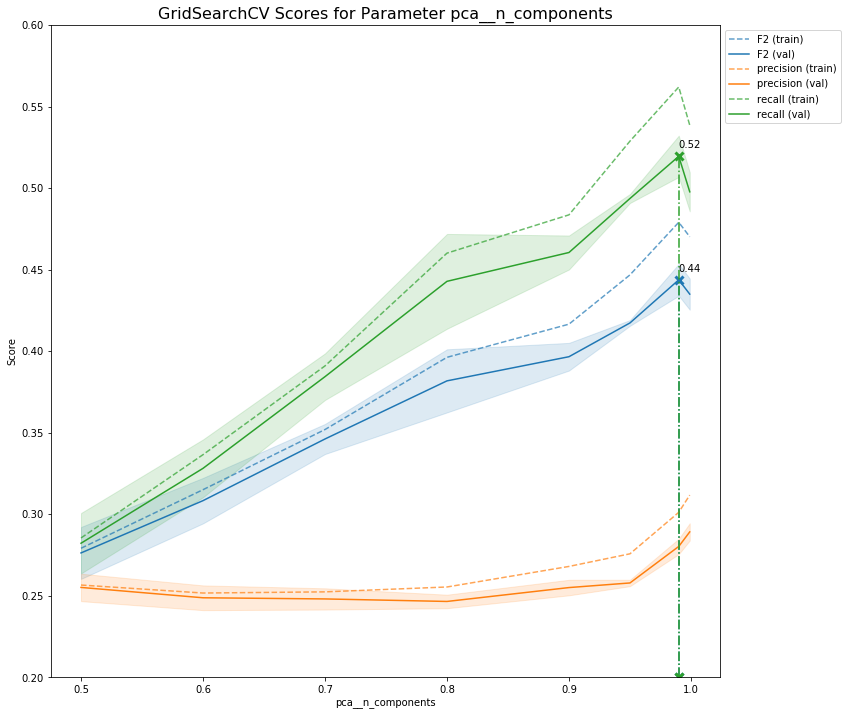

In [26]:
my_func.plot_gs_param(psvc_pca_gs, ylim=(0.2, 0.6))

In [31]:
my_func.gs_score_summary(psvc_pca_gs);

--------------------
Best F2:
Params: {'pca__n_components': 0.99}
F2 = 0.44377181197180515
Recall = 0.5195298792557402
Precision = 0.28029981945763094
--------------------
Best Recall:
Params: {'pca__n_components': 0.99}
F2 = 0.44377181197180515
Recall = 0.5195298792557402
Precision = 0.28029981945763094
--------------------
Best Precision:
Params: {'pca__n_components': None}
F2 = 0.4288440001690372
Recall = 0.4870677256532066
Precision = 0.29016962361093324
--------------------


In [38]:
psvc_pca = Pipeline([('pca', PCA(n_components=0.99)),
                     ('estimator', SVC(kernel='poly', degree=2, class_weight='balanced'))])

psvc_pca.fit(X_train_s, y_train_s)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('estimator', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [39]:
my_func.print_cvs(cross_val_score(psvc_pca, X_train_s, y_train_s, scoring=f2_score))

Mean CV score = 0.461 (+/- 0.001)


In [40]:
my_func.classifier_summary(y_train_s, psvc_pca.predict(X_train_s));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               22192               10078
Actual Positive                3303                4427
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.487287
Recall           0.572704
Precision (pos)  0.305205
Precision (neg)  0.870445
Specificity      0.687698


In [41]:
my_func.classifier_summary(y_val, psvc_pca.predict(X_val));

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               16779                7851
Actual Positive                2675                3139
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.458302
Recall           0.539904
Precision (pos)  0.285623
Precision (neg)  0.862496
Specificity      0.681242


##### Parameter Tuning

In [86]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': np.logspace(-9,3,13)}
              

psvc_C_gs = GridSearchCV(estimator=SVC(kernel='poly', degree=2, class_weight='balanced', cache_size=1000),
                          param_grid = param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=3)

my_func.run_time(reset=True)
psvc_C_gs.fit(X_train_s, y_train_s)
my_func.run_time()

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 22.1min


Time: 53min 50s 


[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed: 53.8min finished


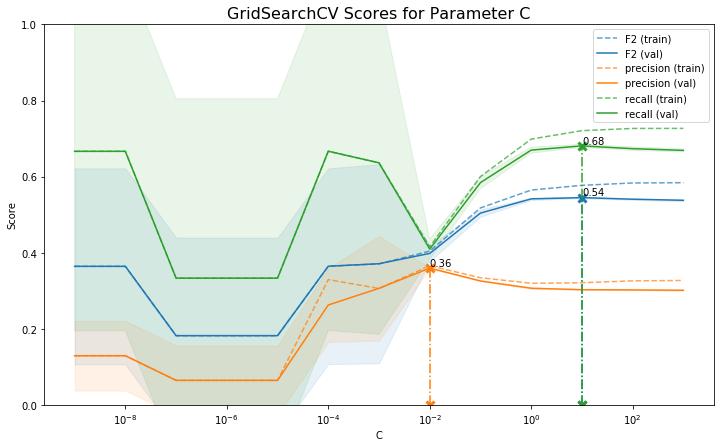

In [87]:
my_func.plot_gs_param(psvc_C_gs, set_xscale='log', figsize=(12,7))

We clearly start seeing volatile and low scoring behavior below C = 0.01, so the ultimate gridsearch should probably limit itself to a C range of 0.001 to 100. The variations seen could also be a symptom of the smaller sample size, but from a computational standpoint it would be expensive to increase it further.

In [20]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'gamma': np.logspace(-9,-1,9)}
              

psvc_d2_g_gs = GridSearchCV(estimator=SVC(kernel='poly', class_weight='balanced', degree=2, tol=0.01, cache_size=1000),
                            param_grid=param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=3)

my_func.run_time(reset=True)
psvc_d2_g_gs.fit(X_train_s, y_train_s)
my_func.run_time()

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Time: 23min 51s 


[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 23.8min finished


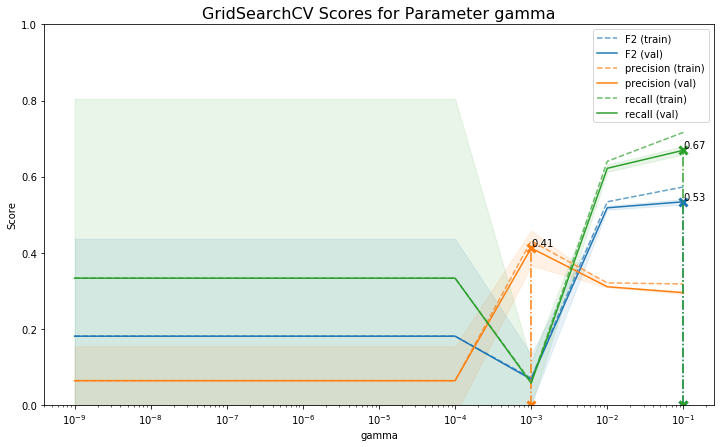

In [21]:
my_func.plot_gs_param(psvc_d2_g_gs, set_xscale='log', figsize=(12,7))

In [24]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision',
         'specificity': make_scorer(my_func.binary_specificity)}

param_grid = {'C': np.logspace(-4,2,7),
              'gamma': np.logspace(-6,-1,6)}
              

psvc_d2_gs = GridSearchCV(estimator=SVC(kernel='poly', degree=2, class_weight='balanced', cache_size=1000),
                          param_grid = param_grid,
                          scoring=scoring,
                          cv=3,
                          refit=False,
                          n_jobs=4,
                          verbose=3)

my_func.run_time(reset=True)
psvc_d2_gs.fit(X_train_s, y_train_s)
my_func.run_time()

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 25.5min


Time: 169min 54s 


[Parallel(n_jobs=4)]: Done 126 out of 126 | elapsed: 169.9min finished


In [25]:
my_func.gs_score_summary(psvc_d2_gs)

--------------------
Best F2:
Params: {'C': 0.0001, 'gamma': 9.9999999999999995e-07}
F2 = 0.5427063865552183
Recall = 1.0
Precision = 0.191825
Specificity = 0.0
--------------------
Best Recall:
Params: {'C': 0.0001, 'gamma': 9.9999999999999995e-07}
F2 = 0.5427063865552183
Recall = 1.0
Precision = 0.191825
Specificity = 0.0
--------------------
Best Precision:
Params: {'C': 100.0, 'gamma': 0.0001}
F2 = 0.06756410155578638
Recall = 0.05734180902934593
Precision = 0.41775001578880894
Specificity = 0.9834502332897544
--------------------
Best Specificity:
Params: {'C': 0.001, 'gamma': 9.9999999999999995e-07}
F2 = 0.0
Recall = 0.0
Precision = 0.0
Specificity = 1.0
--------------------


These best results are obviouslt not acceptable with the corresponding specificity of 0 - essentially these models simply dismiss all loans as default.

In [37]:
psvc_gs_summary = pd.DataFrame({'params': psvc_d2_gs.cv_results_['params'],
                                'F2': psvc_d2_gs.cv_results_['mean_test_F2'],
                                'specificity': psvc_d2_gs.cv_results_['mean_test_specificity'],
                                'precision': psvc_d2_gs.cv_results_['mean_test_precision'],
                                'recall': psvc_d2_gs.cv_results_['mean_test_recall']})

In [44]:
spec_mask = psvc_gs_summary['specificity'] > 0.5
prec_mask = psvc_gs_summary['precision'] > 0.25

psvc_gs_summary[spec_mask & prec_mask].sort_values('F2', ascending=False)

,F2,params,precision,recall,specificity
23,0.537774,"{'C': 0.1, 'gamma': 0.1}",0.298589,0.672487,0.625050
34,0.537774,"{'C': 10.0, 'gamma': 0.01}",0.298589,0.672487,0.625050
40,0.534172,"{'C': 100.0, 'gamma': 0.01}",0.295499,0.669360,0.621215
29,0.534171,"{'C': 1.0, 'gamma': 0.1}",0.295498,0.669360,0.621215
35,0.531885,"{'C': 10.0, 'gamma': 0.1}",0.294646,0.665971,0.621586
41,0.531147,"{'C': 100.0, 'gamma': 0.1}",0.294752,0.664407,0.622668
28,0.518351,"{'C': 1.0, 'gamma': 0.01}",0.311036,0.622050,0.672936
17,0.518340,"{'C': 0.01, 'gamma': 0.1}",0.311017,0.622050,0.672905
39,0.518340,"{'C': 100.0, 'gamma': 0.001}",0.311017,0.622050,0.672905
11,0.420097,"{'C': 0.001, 'gamma': 0.1}",0.345728,0.444025,0.800446


Our next best option whilst maintaing a precision above 0.25 and specificity above 0.5 is with C=0.1 and gamma=0.1. We will see how this model performs:

In [ ]:
psvc_best = SVC(kernel='poly', degree=2, class_weight='balanced', C=0.1, gamma=0.1, cache_size=2000)

my_func.run_time(reset=True)
psvc_best.fit(X_train, y_train)
my_func.run_time()

In [ ]:
my_func.print_cvs(cross_val_score(psvc_best, X_train, y_train, scoring=f2_score))

In [ ]:
my_func.classifier_summary(y_train, psvc_best.predict(X_train))

In [ ]:
my_func.classifier_summary(y_val, psvc_best.predict(X_val))